In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import subprocess
import sys
import tempfile
import time
import typing
import warnings
import zipfile
from functools import partial
from pathlib import Path
from pprint import pprint as ppr

import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import monai
import dipy
import torch
import torch.nn.functional as F
from box import Box
from icecream import ic
from natsort import natsorted

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc


True

In [3]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    # Pick only one device for the default, may use multiple GPUs for training later.
    if "CUDA_PYTORCH_DEVICE_IDX" in os.environ.keys():
        dev_idx = int(os.environ["CUDA_PYTORCH_DEVICE_IDX"])
    else:
        dev_idx = 0
    device = torch.device(f"cuda:{dev_idx}")
    print("CUDA Device IDX ", dev_idx)
    torch.cuda.set_device(device)
    print("CUDA Current Device ", torch.cuda.current_device())
    print("CUDA Device properties: ", torch.cuda.get_device_properties(device))
    # The flag below controls whether to allow TF32 on matmul. This flag defaults to False
    # in PyTorch 1.12 and later.
    torch.backends.cuda.matmul.allow_tf32 = True
    # See
    # <https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices>
    # for details.

    # Activate cudnn benchmarking to optimize convolution algorithm speed.
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = True
        print("CuDNN convolution optimization enabled.")
        # The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
        torch.backends.cudnn.allow_tf32 = True

else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

CUDA Device IDX  0
CUDA Current Device  0
CUDA Device properties:  _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24247MB, multi_processor_count=64)
CuDNN convolution optimization enabled.
cuda:0


## Data Loading

In [4]:
def nib_im_loader(f):
    return nib.as_closest_canonical(nib.load(f))


def nib_fdata_loader(nib_im, dtype=np.float32, **get_fdata_kwargs):
    im = nib_im.get_fdata(**get_fdata_kwargs).astype(dtype)
    if len(im.shape) == 4:
        im = np.moveaxis(im, -1, 0)
    return im

In [5]:
test_subj_ids = list(
    map(
        str,
        [
            # holdout subjects that have been processed
            581450,
            126426,
            191336,
            251833,
            581450,
            601127,
            825048,
            # test set subjects
            110613,
            112112,
            123420,
            124422,
            126628,
            129028,
            130013,
            133019,
            134425,
            135225,
            138837,
            139637,
            139839,
            143830,
            144428,
            144933,
            148840,
            149539,
            150019,
            151526,
            153227,
            153732,
            155231,
            162329,
            187850,
            189349,
            192843,
            193239,
            198451,
            220721,
            268850,
            270332,
            299154,
            314225,
            316633,
            350330,
            368551,
            453542,
            480141,
            492754,
            497865,
            500222,
            519647,
            567961,
            571144,
            656253,
            656657,
            677968,
            683256,
            704238,
            727654,
            731140,
            765056,
            767464,
            917558,
            930449,
            972566,
            978578,
            993675,
            994273,
        ],
    )
)

In [6]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()

In [7]:
# Specify model names and the root directory of the prediction images.
model_names = ["INR 2023-06-20T03_20_54__epoch_49_step_21701", "trilinear"]
model_pred_root_dirs = [
    Path(
        "/data/srv/outputs/pitn/results/runs/2023-06-20T13_25_29_inr-pred-test_native-res/INR"
    ),
    Path(
        "/data/srv/outputs/pitn/results/tmp/2023-06-21T14_51_23_trilin-pred_native-res/trilinear"
    ),
]

for p in model_pred_root_dirs:
    assert p.exists()

In [8]:
subj_data = Box(default_box=True)

for subj_id in test_subj_ids:
    d_i = Box(default_box=True)
    gt_fs = pitn.data.datasets2.HCPfODFINRDataset.get_fodf_subj_dict(
        subj_id, hcp_full_res_fodf_dir
    )

    d_i.gt.f.odf_coeff = gt_fs["fodf"]
    d_i.gt.f.brain_mask = gt_fs["mask"]
    d_i.gt.f.fivett = gt_fs["fivett"]

    d_i.gt.nib.odf_coeff = nib_im_loader(d_i.gt.f.odf_coeff)
    d_i.gt.nib.brain_mask = nib_im_loader(d_i.gt.f.brain_mask)
    d_i.gt.nib.fivett = nib_im_loader(d_i.gt.f.fivett)

    # Break up the fivett into the different tissues.
    fivett = nib_fdata_loader(d_i.gt.nib.fivett, bool, caching="unchanged")
    gm_mask = fivett[0:2].sum(0, keepdims=True).astype(bool)
    d_i.gt.gm_mask = gm_mask
    wm_mask = fivett[2:3]
    d_i.gt.wm_mask = wm_mask
    csf_mask = fivett[3:4]
    d_i.gt.csf_mask = csf_mask
    brain_mask = nib_fdata_loader(d_i.gt.nib.brain_mask, bool, caching="unchanged")
    brain_mask = brain_mask[None] | d_i.gt.gm_mask | d_i.gt.wm_mask | d_i.gt.csf_mask
    d_i.gt.brain_mask = brain_mask

    for name, root_dir in zip(model_names, model_pred_root_dirs):
        pred_f = pitn.utils.system.get_file_glob_unique(
            Path(root_dir).resolve(), f"*{subj_id}*.nii.gz"
        )
        d_i.models[name].f.odf_coeff = pred_f
        d_i.models[name].nib.odf_coeff = nib_im_loader(d_i.models[name].f.odf_coeff)

    subj_data[subj_id] = d_i
    print(subj_id, flush=True, end="...")

# Remove default_box status, to avoid some difficult-to-debug errors later.
_d = Box(default_box=False)
_d.merge_update(subj_data)
subj_data = _d

581450...126426...191336...251833...581450...601127...825048...110613...112112...123420...124422...126628...129028...130013...133019...134425...135225...138837...139637...139839...143830...144428...144933...148840...149539...150019...151526...153227...153732...155231...162329...187850...189349...192843...193239...198451...220721...268850...270332...299154...314225...316633...350330...368551...453542...480141...492754...497865...500222...519647...567961...571144...656253...656657...677968...683256...704238...727654...731140...765056...767464...917558...930449...972566...978578...993675...994273...

## Metrics

In [9]:
# All metrics must take in B x C x X x Y x Z input and target images, and a
# B x 1 x X x Y x Z bool mask, and return B x 1 x X x Y x Z voxel-wise metric images
# with the unmasked voxels set to 0.
sphere = dipy.data.get_sphere("repulsion724")
theta, phi = pitn.odf.get_torch_sample_sphere_coords(sphere, device, torch.float32)


def jsd_metric(input_odf_coeffs, target_odf_coeffs, mask, theta, phi):
    epsilon = 1e-5
    input_sphere_samples = pitn.odf.sample_sphere_coords(
        input_odf_coeffs * mask,
        theta=theta,
        phi=phi,
        sh_order=8,
        sh_order_dim=1,
        mask=mask,
        force_nonnegative=True,
    )
    batch_size = input_odf_coeffs.shape[0]
    n_sphere_samples = input_sphere_samples.shape[1]
    sphere_mask = mask.expand_as(input_sphere_samples)
    # Mask and reshape to (n_vox x batch_size) x n_prob_samples
    input_sphere_samples = einops.rearrange(
        input_sphere_samples[sphere_mask],
        "(b s v) -> (b v) s",
        b=batch_size,
        s=n_sphere_samples,
    )
    # Normalize to sum to 1.0, as a probability density.
    input_sphere_samples /= torch.maximum(
        torch.sum(input_sphere_samples, dim=1, keepdim=True),
        input_odf_coeffs.new_zeros(1) + epsilon,
    )
    target_sphere_samples = pitn.odf.sample_sphere_coords(
        target_odf_coeffs * mask,
        theta=theta,
        phi=phi,
        sh_order=8,
        sh_order_dim=1,
        mask=mask,
    )
    target_sphere_samples = einops.rearrange(
        target_sphere_samples[sphere_mask],
        "(b s v) -> (b v) s",
        b=batch_size,
        s=n_sphere_samples,
    )
    # Normalize to sum to 1.0, as a probability density.
    target_sphere_samples /= torch.maximum(
        torch.sum(target_sphere_samples, dim=1, keepdim=True),
        target_odf_coeffs.new_zeros(1) + epsilon,
    )

    Q_log_in = torch.log(input_sphere_samples.to(torch.float64))
    P_log_target = torch.log(target_sphere_samples.to(torch.float64))
    M_log = torch.log(
        (input_sphere_samples + target_sphere_samples).to(torch.float64) / 2
    )
    del input_sphere_samples, target_sphere_samples
    d_P_M = F.kl_div(M_log, P_log_target, reduction="none", log_target=True)
    # Implement batchmean per-voxel.
    # nan values from the kl divergence occur when the expected density is 0.0 and the
    # log is -inf. The 'contribution' of that element is 0 as the limit approaches 0,
    # so just adding the non-nan values should be valid.
    d_P_M = d_P_M.nansum(1, keepdim=True) / d_P_M.shape[1]

    d_Q_M = F.kl_div(M_log, Q_log_in, reduction="none", log_target=True)
    d_Q_M = d_Q_M.nansum(1, keepdim=True) / d_Q_M.shape[1]

    js_div = d_P_M / 2 + d_Q_M / 2
    js_div = einops.rearrange(js_div, "(b v) s -> (b s v)", b=batch_size, s=1)
    js_dist = torch.zeros_like(mask).to(input_odf_coeffs)
    js_dist.masked_scatter_(mask, torch.sqrt(js_div).to(torch.float32)).to(
        input_odf_coeffs
    )

    return js_dist


def mse_metric(y_pred, y, mask):
    masked_y_pred = y_pred.clone()
    masked_y = y.clone()
    m = mask.expand_as(masked_y)
    masked_y_pred[~m] = torch.nan
    masked_y[~m] = torch.nan
    se = F.mse_loss(masked_y_pred, masked_y, reduction="none")
    mse = torch.nanmean(se, dim=1, keepdim=True)
    return mse

In [10]:
metric_names = ("JSD", "MSE")
metric_fns = (partial(jsd_metric, theta=theta, phi=phi), mse_metric)

## Evaluation

### Voxel-Wise Metrics

In [11]:
voxelwise_metrics_results_table = dict(
    subj_id=list(),
    model=list(),
    tissue_mask=list(),
    metric=list(),
    mean_value=list(),
    std_value=list(),
)

# for every subject
for subj_id, d in subj_data.items():
    print(f"Starting {subj_id}", flush=True, end="...")
    # Load ground truth data and masks.
    gt_odf_coeff = nib_fdata_loader(
        d.gt.nib.odf_coeff, dtype=np.float32, caching="unchanged"
    )[None]
    gt_odf_coeff = torch.from_numpy(gt_odf_coeff).to(device)

    brain_mask = d.gt.brain_mask
    brain_mask = torch.from_numpy(brain_mask).to(device)[None]
    wm_mask = d.gt.wm_mask
    wm_mask = torch.from_numpy(wm_mask).to(device)[None]
    gm_mask = d.gt.gm_mask
    gm_mask = torch.from_numpy(gm_mask).to(device)[None]
    csf_mask = d.gt.csf_mask
    csf_mask = torch.from_numpy(csf_mask).to(device)[None]

    # for every model
    for model_name, d_model in d.models.items():
        print(f"model {model_name}", flush=True, end="...")

        pred_odf_coeff = nib_fdata_loader(
            d_model.nib.odf_coeff, dtype=np.float32, caching="unchanged"
        )[None]
        pred_odf_coeff = torch.from_numpy(pred_odf_coeff).to(device)

        gt_dims = gt_odf_coeff.shape[1]
        pred_dims = pred_odf_coeff.shape[1]
        brain_mask_dims = 1
        x = torch.cat(
            [pred_odf_coeff.cpu(), gt_odf_coeff.cpu(), brain_mask.cpu()], dim=1
        )

        # for every metric
        for metric_name, fn_metric in zip(metric_names, metric_fns):
            print(f"metric {metric_name}", flush=True, end="...")
            if subj_id == "191336":
                pass
            metric_vol = monai.inferers.sliding_window_inference(
                x.cpu(),
                roi_size=(64, 64, 64),
                sw_batch_size=x.shape[0],
                predictor=lambda x: fn_metric(
                    x[:, :pred_dims].to(device, non_blocking=True),
                    x[:, pred_dims : pred_dims + gt_dims].to(device, non_blocking=True),
                    x[:, -brain_mask_dims:].bool().to(device, non_blocking=True),
                ).cpu(),
                overlap=0,
            ).cpu()

            # for all tissue masks
            for tissue_type, mask in zip(
                ("all", "wm", "gm", "csf"), (brain_mask, wm_mask, gm_mask, csf_mask)
            ):
                m = mask.cpu().expand_as(metric_vol.cpu())
                result = metric_vol[m]

                result_mean = result.mean().detach().cpu().item()
                result_std = torch.std(result).detach().cpu().item()
                if np.isnan(result_mean) or np.isnan(result_std):
                    raise RuntimeError(
                        f"ERROR: NaN metric on {subj_id}, {model_name}, {tissue_type}, {metric_name}"
                    )
                voxelwise_metrics_results_table["subj_id"].append(subj_id)
                voxelwise_metrics_results_table["model"].append(model_name)
                voxelwise_metrics_results_table["tissue_mask"].append(tissue_type)
                voxelwise_metrics_results_table["metric"].append(metric_name)
                voxelwise_metrics_results_table["mean_value"].append(result_mean)
                voxelwise_metrics_results_table["std_value"].append(result_std)
    print()

voxelwise_metrics_results_table = pd.DataFrame.from_dict(
    voxelwise_metrics_results_table
)
voxelwise_metrics_results_table.to_csv("voxelwise_metrics_results.csv")
voxelwise_metrics_results_table

Starting 581450...model INR 2023-06-20T03_20_54__epoch_49_step_21701...metric JSD...metric MSE...model trilinear...metric JSD...metric MSE...
Starting 126426...model INR 2023-06-20T03_20_54__epoch_49_step_21701...metric JSD...metric MSE...model trilinear...metric JSD...metric MSE...
Starting 191336...model INR 2023-06-20T03_20_54__epoch_49_step_21701...metric JSD...metric MSE...model trilinear...metric JSD...metric MSE...
Starting 251833...model INR 2023-06-20T03_20_54__epoch_49_step_21701...metric JSD...metric MSE...model trilinear...metric JSD...metric MSE...
Starting 601127...model INR 2023-06-20T03_20_54__epoch_49_step_21701...metric JSD...metric MSE...model trilinear...metric JSD...metric MSE...
Starting 825048...model INR 2023-06-20T03_20_54__epoch_49_step_21701...metric JSD...metric MSE...model trilinear...metric JSD...metric MSE...
Starting 110613...model INR 2023-06-20T03_20_54__epoch_49_step_21701...metric JSD...metric MSE...model trilinear...metric JSD...metric MSE...
Starti

,subj_id,model,tissue_mask,metric,mean_value,std_value
0,581450,INR 2023-06-20T03_20_54__epoch_49_step_21701,all,JSD,0.013304,0.005029
1,581450,INR 2023-06-20T03_20_54__epoch_49_step_21701,wm,JSD,0.008828,0.002578
2,581450,INR 2023-06-20T03_20_54__epoch_49_step_21701,gm,JSD,0.013887,0.003944
3,581450,INR 2023-06-20T03_20_54__epoch_49_step_21701,csf,JSD,0.018053,0.004966
4,581450,INR 2023-06-20T03_20_54__epoch_49_step_21701,all,MSE,0.000215,0.000255
...,...,...,...,...,...,...
1051,994273,trilinear,csf,JSD,0.022114,0.005276
1052,994273,trilinear,all,MSE,0.001495,0.002529
1053,994273,trilinear,wm,MSE,0.003433,0.003501
1054,994273,trilinear,gm,MSE,0.000775,0.001040


In [12]:
voxelwise_metrics_results_table[
    np.isnan(np.array(voxelwise_metrics_results_table.mean_value))
]

,subj_id,model,tissue_mask,metric,mean_value,std_value


<Figure size 1200x2000 with 0 Axes>

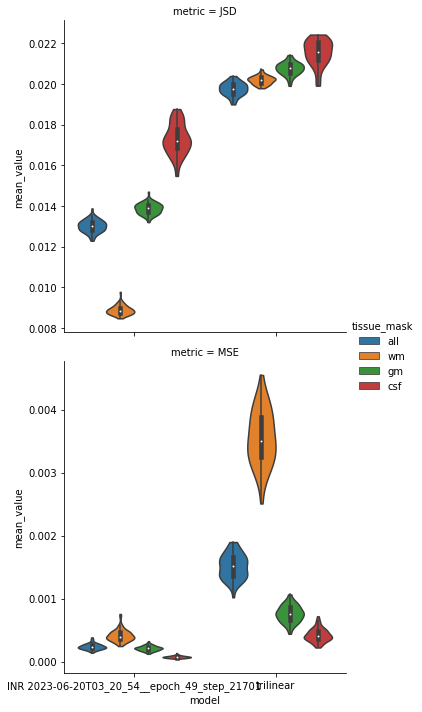

In [30]:
plt.figure(dpi=200, figsize=(6, 10))
sns.catplot(
    voxelwise_metrics_results_table,
    x="model",
    y="mean_value",
    row="metric",
    hue="tissue_mask",
    sharey="row",
    cut=0,
    # kind="strip",
    # jitter=True,
    kind="violin",
    # inner='stick',
    scale="width",
)

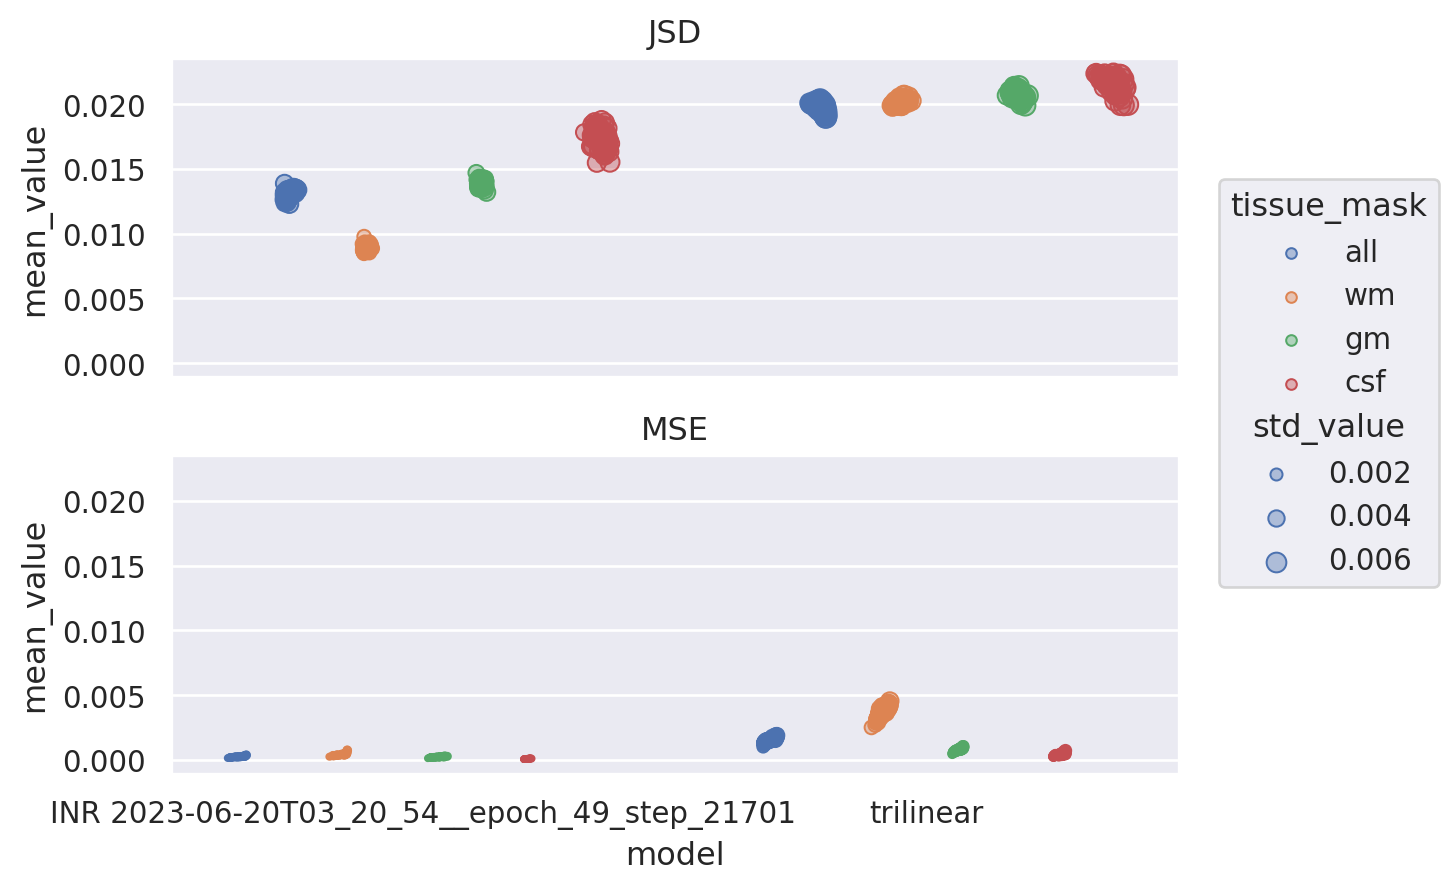

In [16]:
import seaborn.objects as so

p = (
    so.Plot(
        voxelwise_metrics_results_table,
        x="model",
        y="mean_value",
        color="tissue_mask",
        pointsize="std_value",
        # fillalpha=0.8,
    )
    .add(so.Dots(fillalpha=0.4), so.Dodge(), so.Jitter(0.9))
    .facet(row="metric")
)
p